# Explore results after scraping results website

### User variables


In [1]:
Date = '2019-03' # yyyy-mm

### Modules and functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display,Image

### Load results

Load auction results and data from rdw.

In [3]:
file_name = '../data/drz-data-{}.pkl'.format(Date)
print(file_name)
drz = pd.read_pickle(file_name)
file_name = '../data/rdw-data-{}.pkl'.format(Date)
print(file_name)
rdw = pd.read_pickle(file_name)

../data/drz-data-2019-03.pkl
../data/rdw-data-2019-03.pkl


# Cheap cars with valid inspection

In [4]:
is_cheap = (
    drz.LotType == "Personenauto"
) & (
    drz.Price<3000
) & (
    drz.Price>0
) & ~(
    (
        drz.APKdate.isnull()
    ) | (
        drz.APKdate.apply(lambda x:x == '')
    )
)

drz.loc[is_cheap,
        ["Price","ItemType","ItemBrand","Mfdate","APKdate","OdoKM"]]

,Price,ItemType,ItemBrand,Mfdate,APKdate,OdoKM
2019-3-2222,1051.0,audi 80 c 44 kw,AUTO UNION,27.04.1984,16.10.2020,142.518
2019-3-8100,2921.0,308,PEUGEOT,31.10.2008,14.03.2019,233.385
2019-3-8101,444.0,megane; 2.0 16v,RENAULT,08.01.2004,07.09.2019,293.143
2019-3-8112,1011.0,astra; h-cc z17dth,OPEL,29.10.2004,16.11.2019,293.141
2019-3-8113,500.0,corolla 1.3 3d hb xli-e2,TOYOTA,03.01.1994,26.11.2019,120.098
2019-3-8120,1881.0,twingo,RENAULT,20.10.2011,01.07.2019,229.183
2019-3-8121,1758.0,megane scenic,RENAULT,29.06.2007,28.03.2019,177.459
2019-3-8127,921.0,c4 picasso,CITROËN,20.05.2009,10.09.2019,382.216
2019-3-8131,889.0,ibiza; 1.9 tdi/pd 96kw,SEAT,02.05.2003,13.06.2019,348.138
2019-3-8144,359.0,golf; 74 kw,VOLKSWAGEN,05.10.1999,16.07.2019,220.806


In [5]:
rdw.loc[is_cheap,["rdwinfo"]]

,rdwinfo
2019-3-2222,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-3-8100,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-3-8101,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-3-8112,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-3-8113,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-3-8120,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-3-8121,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-3-8127,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-3-8131,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-3-8144,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."


In [6]:
rdw.loc[is_cheap,"rdwinfo"][0]

{'aantal_cilinders': {0: 4},
 'aantal_deuren': {0: 4},
 'aantal_wielen': {0: 4},
 'aantal_zitplaatsen': {0: 5},
 'afstand_hart_koppeling_tot_achterzijde_voertuig': {0: 0},
 'afstand_voorzijde_voertuig_tot_hart_koppeling': {0: 0},
 'api_gekentekende_voertuigen_assen': {0: 'https://opendata.rdw.nl/resource/3huj-srit.json'},
 'api_gekentekende_voertuigen_brandstof': {0: 'https://opendata.rdw.nl/resource/8ys7-d773.json'},
 'api_gekentekende_voertuigen_carrosserie': {0: 'https://opendata.rdw.nl/resource/vezc-m2t6.json'},
 'api_gekentekende_voertuigen_carrosserie_specifiek': {0: 'https://opendata.rdw.nl/resource/jhie-znh9.json'},
 'api_gekentekende_voertuigen_voertuigklasse': {0: 'https://opendata.rdw.nl/resource/kmfi-hrps.json'},
 'breedte': {0: 0},
 'cilinderinhoud': {0: 1296},
 'datum_eerste_afgifte_nederland': {0: 20160711},
 'datum_eerste_toelating': {0: 19840427},
 'datum_tenaamstelling': {0: 20190213},
 'eerste_kleur': {0: 'WIT'},
 'europese_voertuigcategorie': {0: 'M1'},
 'export_ind

In [7]:
pd.DataFrame(rdw.loc[is_cheap,"rdwinfo"][0]).T

,0,1
aantal_cilinders,4,NaN
aantal_deuren,4,NaN
aantal_wielen,4,NaN
aantal_zitplaatsen,5,NaN
afstand_hart_koppeling_tot_achterzijde_voertuig,0,NaN
afstand_voorzijde_voertuig_tot_hart_koppeling,0,NaN
api_gekentekende_voertuigen_assen,https://opendata.rdw.nl/resource/3huj-srit.json,NaN
api_gekentekende_voertuigen_brandstof,https://opendata.rdw.nl/resource/8ys7-d773.json,NaN
api_gekentekende_voertuigen_carrosserie,https://opendata.rdw.nl/resource/vezc-m2t6.json,NaN
api_gekentekende_voertuigen_carrosserie_specifiek,https://opendata.rdw.nl/resource/jhie-znh9.json,NaN


# Pictures of lots

In [8]:
# ix=drz.N_images.idxmax()
ix=drz.Price.idxmax(); print('Price: EUR {:g}\n\n'.format(drz.loc[ix,'Price']))
# Mfdate = drz.Mfdate.apply(lambda x: pd.to_datetime(x,format='%d.%m.%Y') if len(x)==10 else pd.np.NaN)
# ix=Mfdate.idxmin(); print('year of mf: {:s}\n\n'.format(drz.loc[ix,'Mfdate']))
# ix = '2019-2-2005' # largest km/day
# ix = '2019-2-7345' # largest km

print(ix)
for u in drz.loc[ix,'Images']:
    print(u)
    print(drz.loc[ix,'Source'])
    display(Image(url=u,width=400))
    

Price: EUR 160016


2019-3-2413
http://www.domeinenrz.nl/ufc/static/1551260989/thumb/domeinenrz_sites/ec732db3584abdae26b23637d46b9b0d/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0003_maart?=&veilingen=2019-0003&meerfotos=K1900032413


http://www.domeinenrz.nl/ufc/static/1551260987/thumb/domeinenrz_sites/b0c35bf0c011c1adf3b3c8191fdef3f8/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0003_maart?=&veilingen=2019-0003&meerfotos=K1900032413


http://www.domeinenrz.nl/ufc/static/1551260982/thumb/domeinenrz_sites/50245eae66d4f9c7606434fb519856c0/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0003_maart?=&veilingen=2019-0003&meerfotos=K1900032413


http://www.domeinenrz.nl/ufc/static/1551260986/thumb/domeinenrz_sites/a42ff9c3402e25de69da59eeaac9aa94/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0003_maart?=&veilingen=2019-0003&meerfotos=K1900032413


http://www.domeinenrz.nl/ufc/static/1551260989/thumb/domeinenrz_sites/f0ba67f5a535343f8fc393624f36bc51/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0003_maart?=&veilingen=2019-0003&meerfotos=K1900032413


http://www.domeinenrz.nl/ufc/static/1551260986/thumb/domeinenrz_sites/a8ec4b051f83847813df61069167d312/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0003_maart?=&veilingen=2019-0003&meerfotos=K1900032413


http://www.domeinenrz.nl/ufc/static/1551260987/thumb/domeinenrz_sites/b0aa81a331e4eebdf419e3762ddfb246/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0003_maart?=&veilingen=2019-0003&meerfotos=K1900032413


http://www.domeinenrz.nl/ufc/static/1551260983/thumb/domeinenrz_sites/6364e6db73e5d9680697e7112efb2a4e/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0003_maart?=&veilingen=2019-0003&meerfotos=K1900032413


# Usage

How many km are driven per year or day?

### Odometer conversion

In [9]:
def odo_str2float(df):
    '''
    Convert odometer to numerical values.
    Also convert Miles to KMs.
    '''
    
    ml2km = 1.609344
    
    # substitute to nan
    df.OdoKM = df.OdoKM.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    df.OdoMLS = df.OdoMLS.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    # float
    df["OdoKM_num"] = df.OdoKM.apply(lambda x:x.replace('.','')).astype(float)
    df["OdoMLS_num"] = df.OdoMLS.apply(lambda x:x.replace('.','')).astype(float)
    # convert miles to km
    df["Odo"] = df.OdoKM_num.copy()
    chooseMls = (df.OdoKM_num.isna()) & ~(df.OdoMLS_num.isna())
    df.loc[chooseMls,"Odo"] = df.loc[chooseMls,"OdoMLS_num"].apply(float) * ml2km

In [10]:
odo_str2float(drz)

drz[['Odo','OdoKM','OdoKM_num','OdoMLS','OdoMLS_num']]

,Odo,OdoKM,OdoKM_num,OdoMLS,OdoMLS_num
2019-3-1800,14229.000000,14.229,14229.0,nan,NaN
2019-3-1801,10059.000000,10.059,10059.0,nan,NaN
2019-3-1802,6199.000000,6.199,6199.0,nan,NaN
2019-3-1803,34986.000000,34.986,34986.0,nan,NaN
2019-3-1804,19737.000000,19.737,19737.0,nan,NaN
2019-3-1805,9009.000000,9.009,9009.0,nan,NaN
2019-3-1806,9306.000000,9.306,9306.0,nan,NaN
2019-3-1808,28609.000000,28.609,28609.0,nan,NaN
2019-3-1809,10000.000000,10.000,10000.0,nan,NaN
2019-3-1810,8098.000000,8.098,8098.0,nan,NaN


### Dates

In [11]:
AuctDate = pd.to_datetime(drz.index[0][0:-5], format = '%Y-%m')

# serial date
drz["Mfdate_ser"] = drz.Mfdate.apply(lambda x:pd.to_datetime(x, format = '%d.%m.%Y') if x!='' else pd.np.NaN)

# age
drz["Age"] = (AuctDate - drz.Mfdate_ser)
drz["Age_year"] = drz.Age.apply(lambda x:x.days/365.25)

- - - -
# Continue with cars only

In [12]:
out = drz.Price.copy()
Features = drz.loc[:,["ItemBrand","ItemType","Odo","Age_year"]].copy()

In [13]:
# Drop rows
Subsel = drz.LotType == 'Personenauto'
dropIx=drz[~Subsel].index
out.drop(index=dropIx,inplace=True)
Features.drop(index=dropIx,inplace=True)

### one hot encoding brand and model

In [14]:
Dummies = pd.get_dummies(Features.ItemBrand,prefix='Brand_',drop_first=False)
Features = pd.concat([Features,Dummies],axis=1)

Features.describe()

,Odo,Age_year,Brand__ALFA ROMEO,Brand__AUDI,Brand__AUTO UNION,Brand__BMW,Brand__CHEVROLET,Brand__CITROËN,Brand__FIAT,Brand__FORD,...,Brand__RENAULT,Brand__ROLLS ROYCE,Brand__ROVER,Brand__SAAB,Brand__SEAT,Brand__SKODA,Brand__SUZUKI,Brand__TOYOTA,Brand__VOLKSWAGEN,Brand__VOLVO
count,141.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,...,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,196434.291854,12.304109,0.013793,0.075862,0.006897,0.089655,0.013793,0.055172,0.048276,0.048276,...,0.055172,0.006897,0.006897,0.006897,0.034483,0.013793,0.013793,0.020690,0.172414,0.041379
std,86576.448520,5.368502,0.117036,0.265695,0.083045,0.286677,0.117036,0.229108,0.215092,0.215092,...,0.229108,0.083045,0.083045,0.083045,0.183098,0.117036,0.117036,0.142837,0.379049,0.199856
min,24206.000000,2.913073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,130928.000000,7.728953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,194175.000000,12.903491,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,249866.000000,16.161533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,425839.000000,34.841889,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Plotting

In [15]:
def ecdf(data):
    x = sorted(data)
    y = pd.np.arange(0,len(x))/len(x)
    return x,y

# # example
# x,y = ecdf(km_p_day)
# plt.plot(x,y)

In [16]:
# km per day
km_p_day = Features.Odo/(Features.Age_year*365.25).fillna(0)
sel = ~(km_p_day.isna() | (km_p_day == pd.np.inf))
km_p_day = km_p_day.loc[sel]

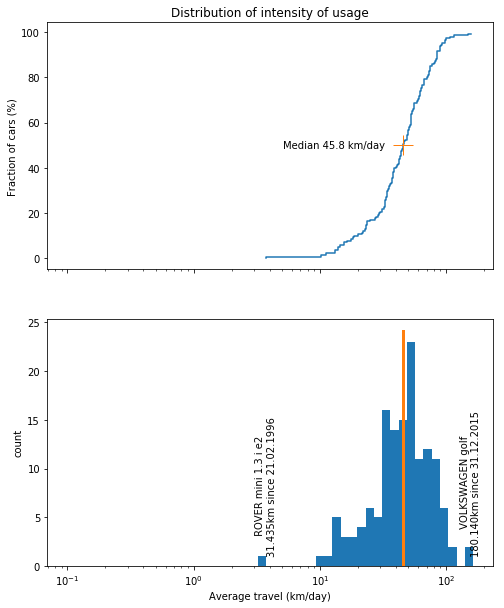

In [17]:
# Plot ecdf and hist
x,y = ecdf(km_p_day)
fig,axs = plt.subplots(ncols=1,nrows=2, figsize=[8,10],sharex=True)

# ecdf
ax = axs[0]
ax.step(x,y*100)
ax.plot(pd.np.median(x),50,'+',markersize=20)
ax.text(pd.np.median(x),50,'Median {:.1f} km/day      '.format(pd.np.median(x)),ha='right',va='center');
ax.set_title('Distribution of intensity of usage')
ax.set_ylabel('Fraction of cars (%)')

xl = axs[0].get_xlim()

# hist
ax = axs[1]
ax.hist(x,bins=pd.np.logspace(-1,pd.np.log10(xl[1]),50))
yl = axs[1].get_ylim()
ax.plot(pd.np.array([1,1])*pd.np.median(x),yl,'-',linewidth=3)
ax.set_xlabel('Average travel (km/day)')
ax.set_ylabel('count')

ax.text(
    km_p_day.min(),1,
    ' {} {}\n{}km since {}'.format(*rdw.loc[km_p_day.idxmin(),['ItemBrand','ItemType','OdoKM','Mfdate']].values),
    rotation=90,
    va='bottom',
    ha='center'
)

ax.text(
    km_p_day.max(),1,
    ' {} {}\n{}km since {}'.format(*rdw.loc[km_p_day.idxmax(),['ItemBrand','ItemType','OdoKM','Mfdate']].values),
    rotation=90,
    va='bottom',
    ha='center'
)

ax.set_xscale('log')


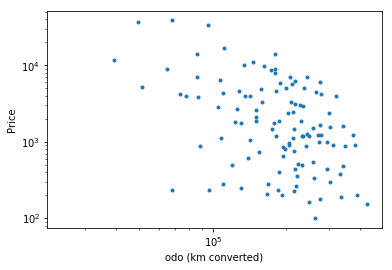

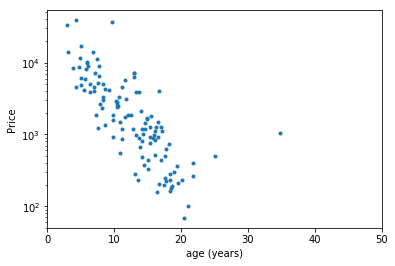

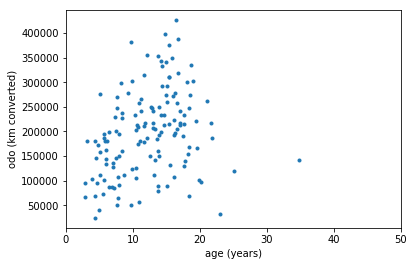

In [18]:
plt.plot(Features.Odo,out,'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('odo (km converted)')
plt.ylabel('Price')

plt.figure()
plt.plot(Features.Age_year,out,'.')
plt.yscale('log')
plt.xlabel('age (years)')
plt.ylabel('Price')
plt.xlim(0,50)


plt.figure()
plt.plot(Features.Age_year,Features.Odo,'.')
plt.xlabel('age (years)')
plt.ylabel('odo (km converted)')
plt.xlim(0,50)

plt.show()



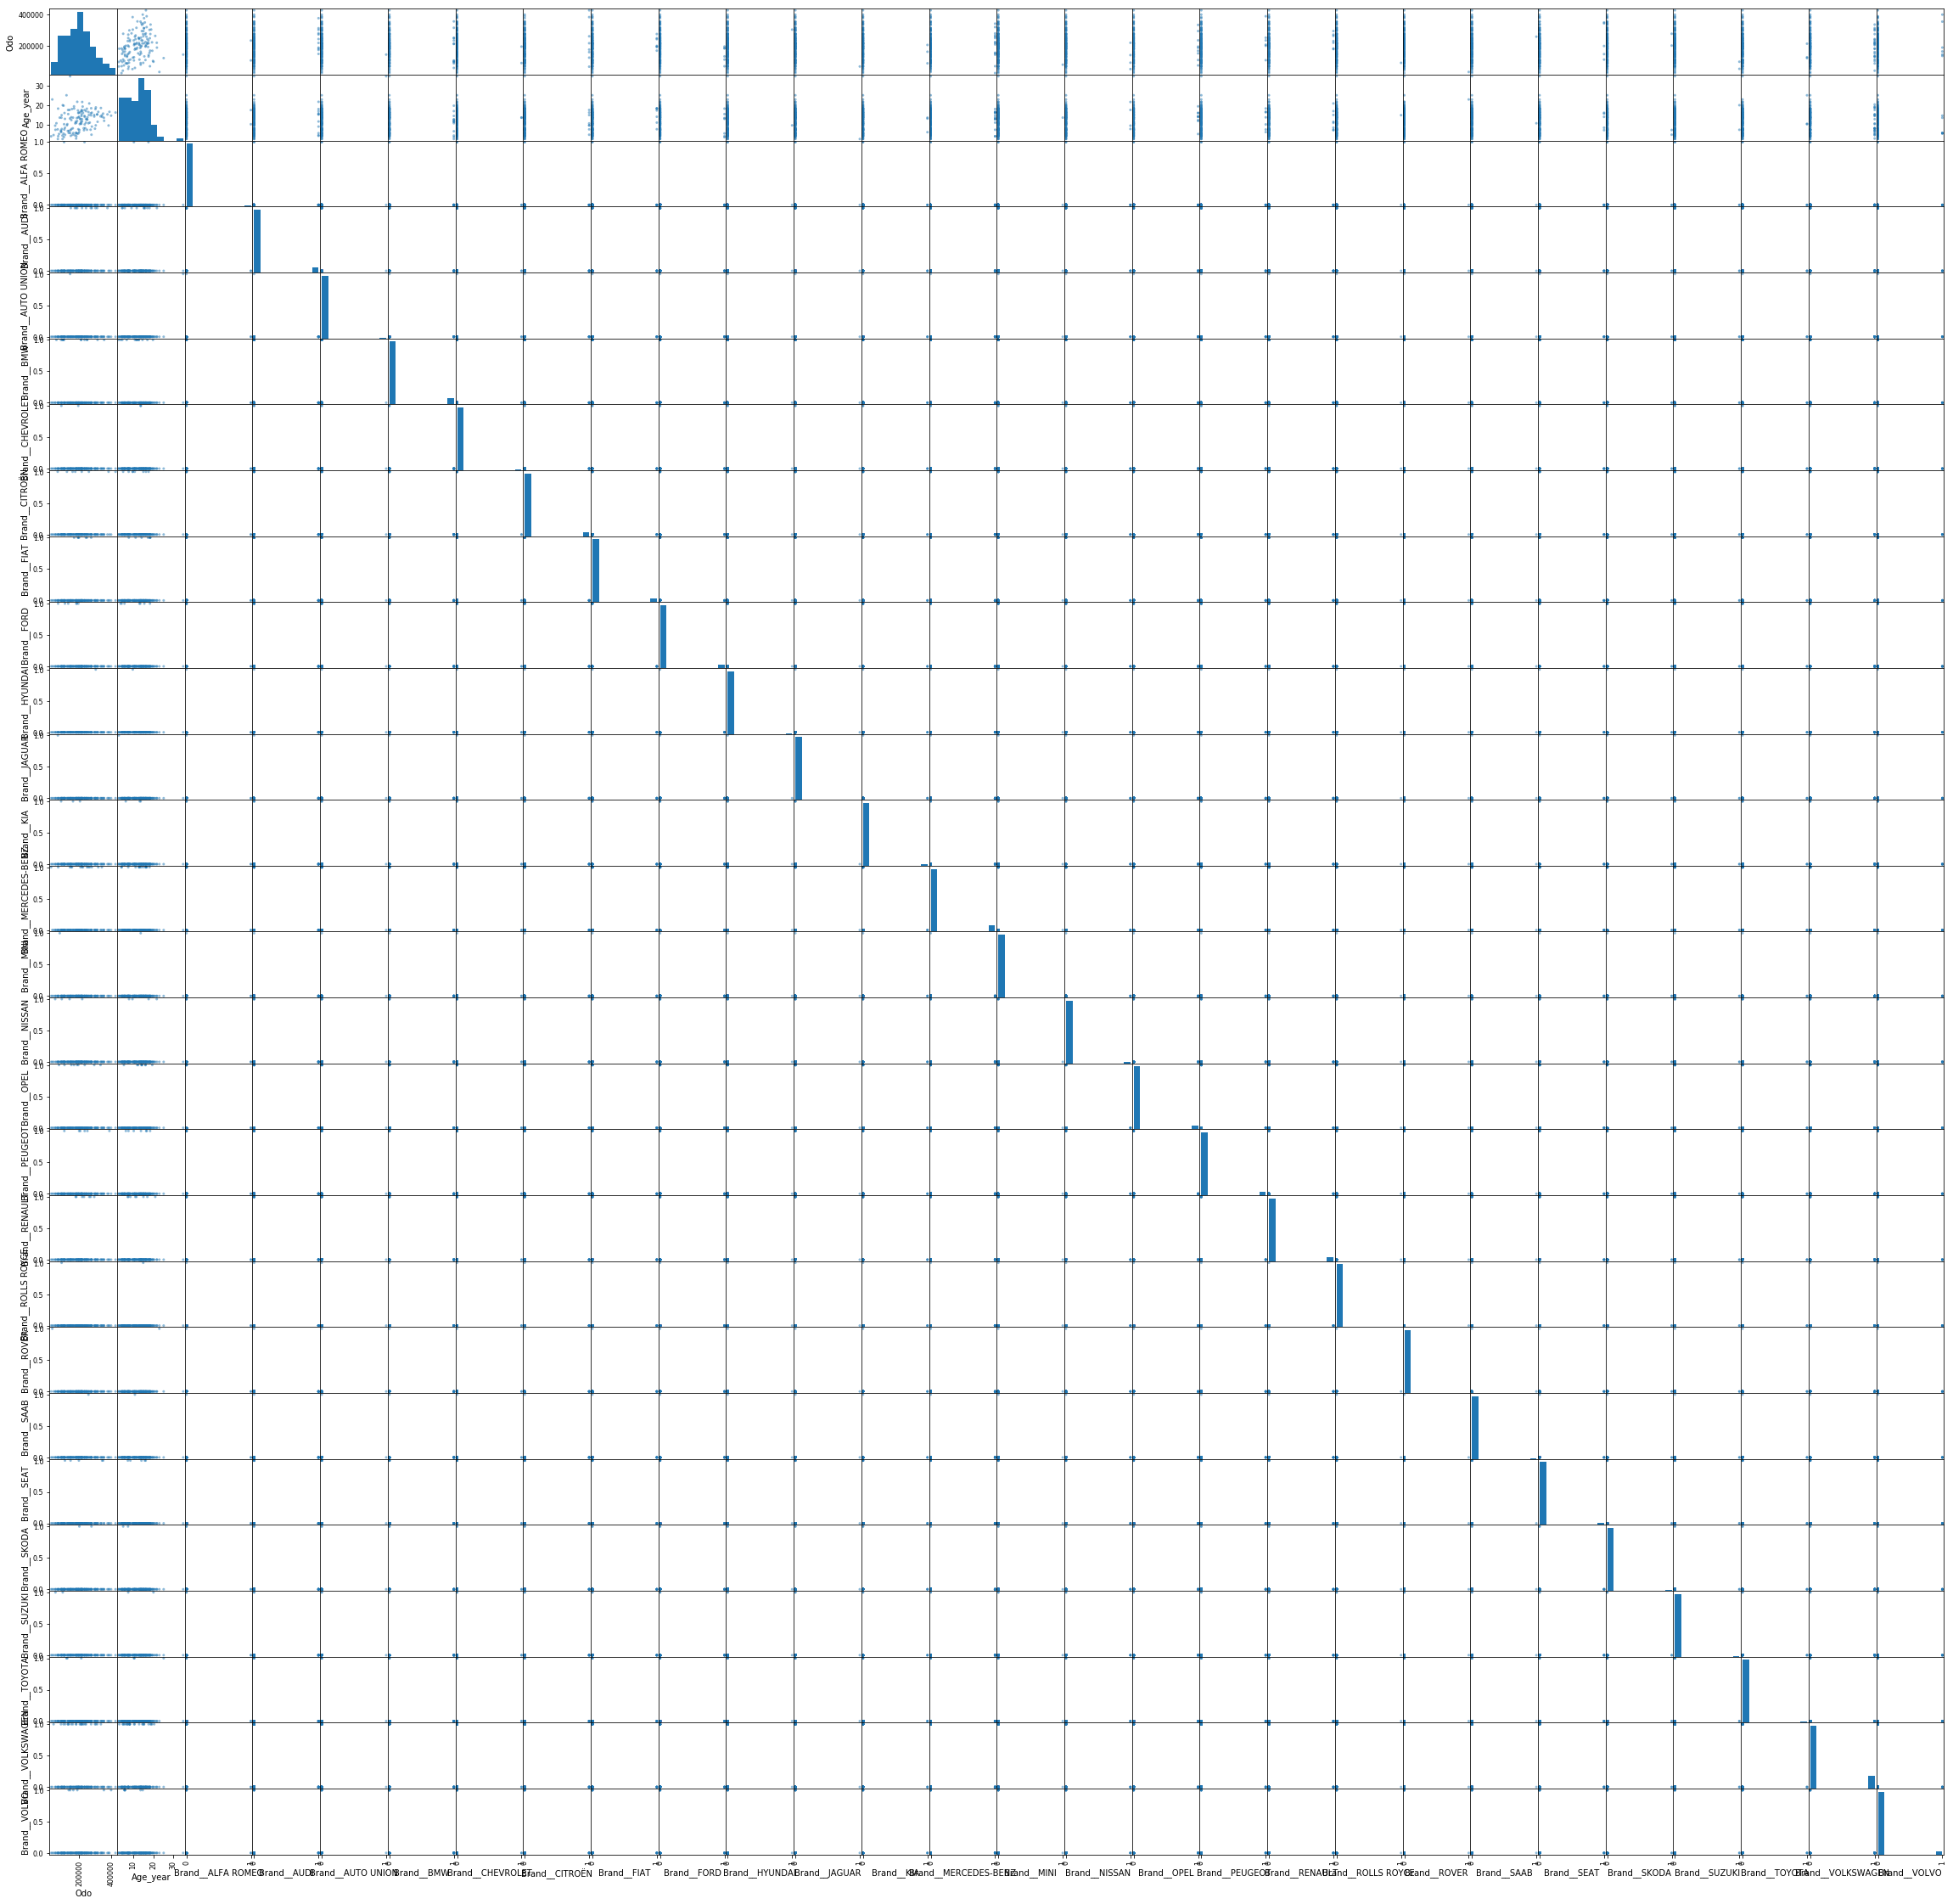

In [19]:
pd.plotting.scatter_matrix(Features,figsize=[40,40])
plt.show()